In [2]:
import torch
import gymnasium as gym
import sys
import tqdm
import numpy as np
import os
import copy
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

from src.environments.frozen_env import FrozenActions, make_frozen_env
from src.agents.LLaVa15_agent import LLaVa15Agent

Appending to sys.path: ['/mnt/llmdata/home/gbonetta/progetti/rocket', '/mnt/llmdata/home/gbonetta/progetti/rocket/src']


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
There was a problem when trying to write in your cache folder (/data01/gbonetta/). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FrozenLakeText-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi3Disk-v0 already in registry.
  logger.warn(f"Overriding environment {

In [3]:
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

In [4]:
LOCAL_NUM_ENVS = 2
SEED = 1234

In [5]:
is_crafter = False 
envs = gym.vector.SyncVectorEnv(
    [make_frozen_env(
        "/mnt/llmdata/home/gbonetta/progetti/rocket/tests/run_dir_prova",
        map_size=8, # 8x8
        is_slippery=False,
        save_video=False,
        save_video_every=20
    )
    for i in range(LOCAL_NUM_ENVS)
    ]
)

TypeError: make_frozen_env() got an unexpected keyword argument 'map_size'

In [5]:
from enum import Enum
class CustomActions(Enum):
    move_left = "move west"
    move_down = "move south"
    move_right = "move east"
    move_up = "move north"

actions = [action.value for action in CustomActions]
print(actions)

['move west', 'move south', 'move east', 'move north']


In [6]:

agent = LLaVa15Agent("llava-hf/llava-1.5-13b-hf",
                            action_enum=CustomActions, 
                            is_lora=True,
                            padding_side="right", 
                            num_prompt_images=1, 
                            use_text_description=True, 
                            gradient_ckpt=False)
agent.critic.to('cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


trainable params: 129,892,352 || all params: 13,481,387,008 || trainable%: 0.9634939782006146


Sequential(
  (0): Linear(in_features=5120, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
agent.network.eval()
agent.critic.eval()

Sequential(
  (0): Linear(in_features=5120, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
agent.config

LlavaConfig {
  "_name_or_path": "llava-hf/llava-1.5-13b-hf",
  "architectures": [
    "LlavaForCausalLM"
  ],
  "ignore_index": -100,
  "image_token_index": 32000,
  "model_type": "llava",
  "pad_token_id": 32001,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "meta-llama/Llama-2-13b-hf",
    "architectures": [
      "LlamaForCausalLM"
    ],
    "hidden_size": 5120,
    "intermediate_size": 13824,
    "max_position_embeddings": 4096,
    "model_type": "llama",
    "num_attention_heads": 40,
    "num_hidden_layers": 40,
    "num_key_value_heads": 40,
    "rms_norm_eps": 1e-05,
    "torch_dtype": "float16",
    "vocab_size": 32064
  },
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.38.2",
  "vision_config": {
    "hidden_size": 1024,
    "image_size": 336,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "project

In [9]:
TEMPERATURE = 0.1

/home/gbonetta/miniconda3/envs/crafter_smart/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


step=0, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: mov

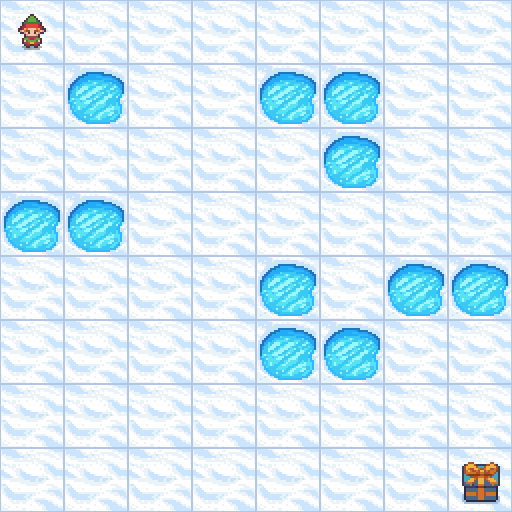

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[2.1942e-04, 9.0104e-01, 7.3962e-02, 2.4774e-02],
        [1.3421e-04, 9.1577e-01, 6.9522e-02, 1.4573e-02]], device='cuda:0')

step=1, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting posi

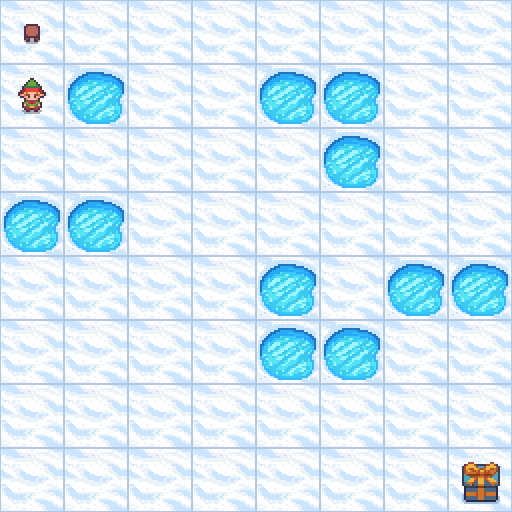

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[4.2486e-04, 8.9808e-01, 7.3410e-04, 1.0076e-01],
        [2.0149e-05, 9.3226e-01, 1.1735e-02, 5.5986e-02]], device='cuda:0')

step=2, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a dea

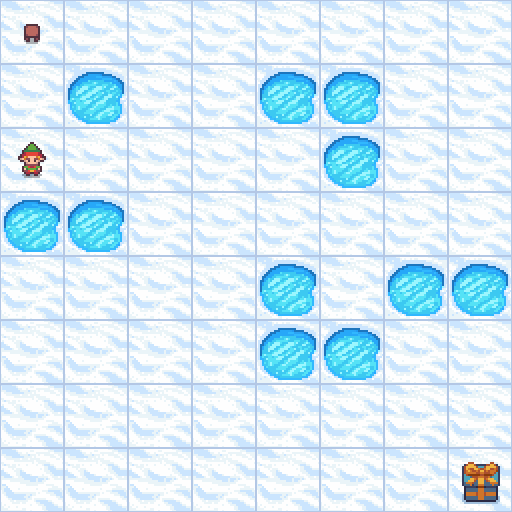

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[1.1140e-04, 5.1432e-01, 4.5648e-02, 4.3992e-01],
        [2.8255e-05, 9.5641e-01, 1.9239e-02, 2.4320e-02]], device='cuda:0')

step=3, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n a wall north of you, normal ground south of you

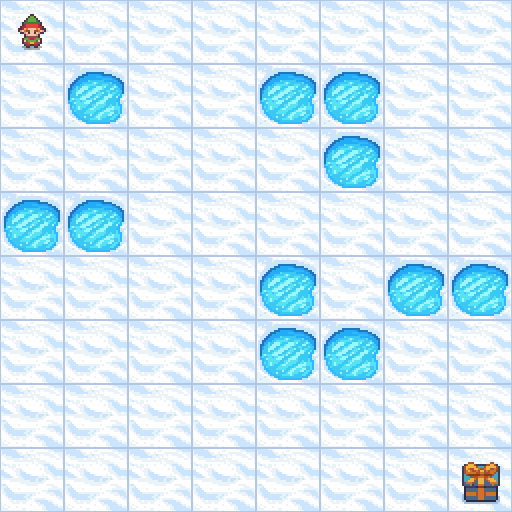

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[2.1942e-04, 9.0104e-01, 7.3962e-02, 2.4774e-02],
        [2.2322e-05, 9.5515e-01, 1.6434e-02, 2.8396e-02]], device='cuda:0')

step=4, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting posi

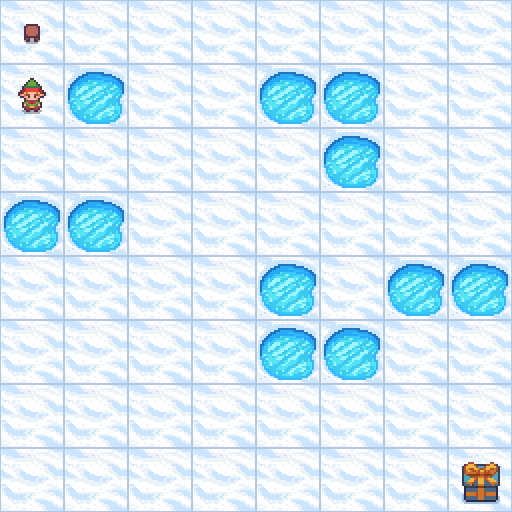

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[4.2486e-04, 8.9808e-01, 7.3410e-04, 1.0076e-01],
        [2.2392e-05, 9.5817e-01, 1.9274e-02, 2.2534e-02]], device='cuda:0')

step=5, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a dea

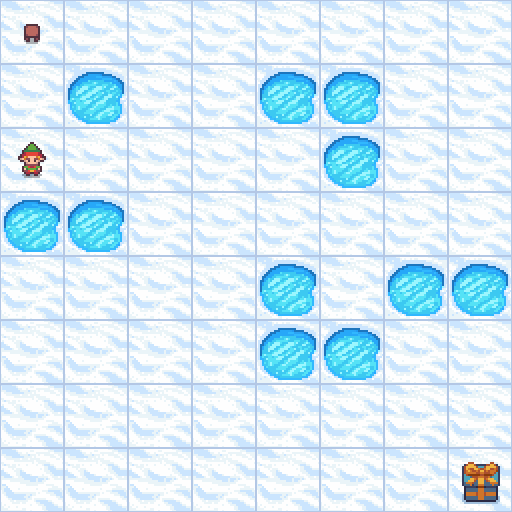

action=tensor([3, 1], device='cuda:0'), ['move north', 'move south'], probstensor([[1.1140e-04, 5.1432e-01, 4.5648e-02, 4.3992e-01],
        [2.8211e-05, 9.5492e-01, 2.0770e-02, 2.4282e-02]], device='cuda:0')

step=6, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting position north of you, normal ground south of you, a wall west of you, a deadly trap east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n the starting posi

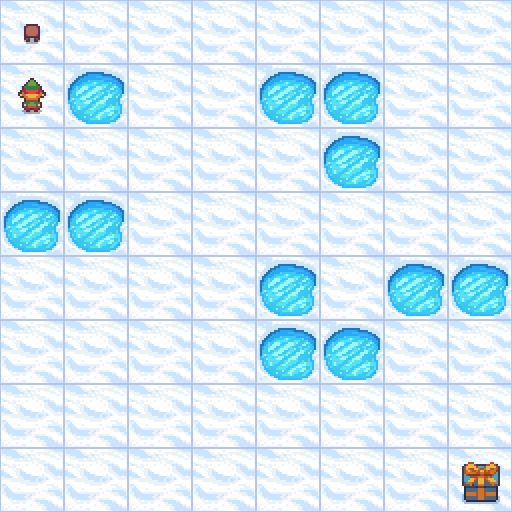

action=tensor([1, 1], device='cuda:0'), ['move south', 'move south'], probstensor([[3.9594e-04, 9.0496e-01, 7.3972e-04, 9.3903e-02],
        [2.9214e-05, 9.5101e-01, 2.0685e-02, 2.8273e-02]], device='cuda:0')

step=7, ["User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move west", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a deadly trap south of you, a wall west of you, normal ground east of you. The goal is south east of you. What's the next best action? You must avoid the traps! Choose among [move west, move south, move east, move north]\nASSISTANT: move south", "User: <image>\nYou are an agent in a survival 2D game. you see:\n normal ground north of you, a dea

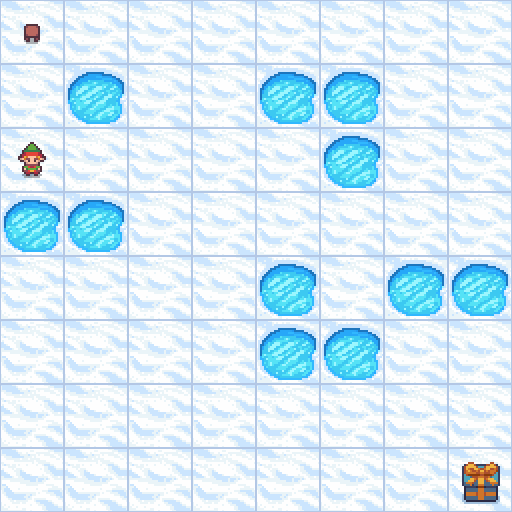

action=tensor([1, 2], device='cuda:0'), ['move south', 'move east'], probstensor([[1.1140e-04, 5.1432e-01, 4.5648e-02, 4.3992e-01],
        [8.4152e-04, 8.4329e-03, 7.8320e-01, 2.0753e-01]], device='cuda:0')



In [11]:
next_obs, infos = envs.reset(seed=SEED)
next_obs = torch.Tensor(next_obs).to('cuda')
next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)

for step in range(8):
    with torch.no_grad():
        res = agent.get_action_and_value(next_obs, text_description=next_text_obs, temperature=TEMPERATURE)
        action, logprob, value = res['action'], res['log_prob'], res['values']
        print(f"{step=}, {res['prompts']}")
        print(f"{step=}, {res['just_context_prompt']}")
        #print(f"{next_obs[0].permute(2, 0, 1).to(torch.int)}")

        to_pil = transforms.ToPILImage()
        pil_image = to_pil(transforms.functional.invert(next_obs[0].permute(2, 0, 1)))
        display(pil_image)
        #pil_image = transforms.functional.to_pil_image(next_obs[0].permute(2, 0, 1))
        #print(next_obs[0].permute(2, 0, 1))
        #display(pil_image)

        #scaled_logits = res['action_logits'] / TEMPERATURE
        #probs = Categorical(logits=scaled_logits)
        #action = probs.sample()
        #action = torch.argmax(scaled_logits).unsqueeze(0)

        print(f"{action=}, {[actions[a.item()] for a in action]}, probs{F.softmax(res['action_logits'], dim=-1)}\n")

        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)

        next_obs = torch.Tensor(next_obs).to('cuda')

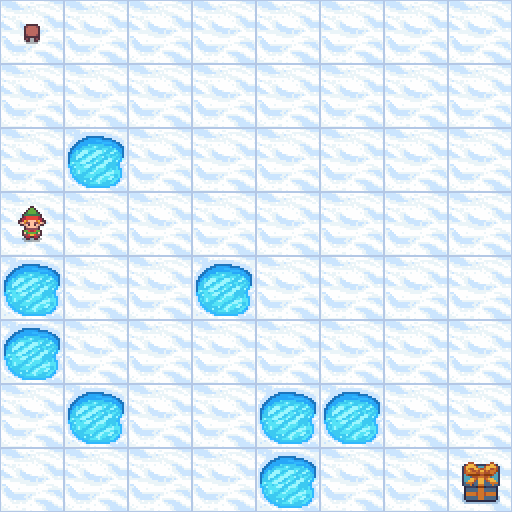

['<s> USER: <image> \nThe elf in the picture observes the following surroundings:\n- Regular ground one step to his right.\n- A trap one step below him.\n- Regular ground one step above him.\n- A wall one step to his left.\nHis objective is to reach the gift located at the bottom of the image, while steering clear of the traps.\nWhat would be the optimal next move for him: moving one step to the left, down, right, or up?\nASSISTANT: The optimal next move for the elf would be to move one step down, as this would help him avoid the trap and move closer to the gift.</s>']


: 

In [17]:

#message = res['just_context_prompt'] #conversation = [{"role": "user", "content": message}]
#image = res['just_context_prompt'][0][1]

display(pil_image)

prompt = [
"""USER: <image>\nThe elf in the picture observes the following surroundings:
- Regular ground one step to his right.
- A trap one step below him.
- Regular ground one step above him.
- A wall one step to his left.
His objective is to reach the gift located at the bottom of the image, while steering clear of the traps.
What would be the optimal next move for him: moving one step to the left, down, right, or up?\nASSISTANT:"""
]
#input_ids = tokenizer.apply_chat_template(conversation, tokenize=False)
context_prompt = agent.processor(prompt, images=[pil_image], return_tensors="pt", padding=True).to('cuda')
result = agent.network.generate(**context_prompt, max_new_tokens=200)
print(agent.processor.tokenizer.batch_decode(result))